## Table of Contents
1. [Class Distribution](#class)
2. [Cleaning and Preprocessing Data](#clean)
3. [EDA](#eda)

In [32]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import RegexpTokenizer
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from nltk.corpus import stopwords
import string
from nltk import FreqDist
from wordcloud import WordCloud
from scipy import sparse
from sklearn.feature_extraction.text import TfidfVectorizer
from custom import * #personal functions
import pickle

In [2]:
df = pd.read_pickle('../Data/reviews.pkl')

In [3]:
df.head()

,Review,Score
0,\n Keough's...,fresh
1,\n While Th...,fresh
2,"\n If ""The ...",fresh
3,"\n ""The Lod...",fresh
4,\n There's ...,rotten


In [4]:
df.shape

(9174, 2)

# Class Distribution

How many reviews do we have in each category?

In [5]:
df['Score'].value_counts()

fresh     5057
rotten    4117
Name: Score, dtype: int64

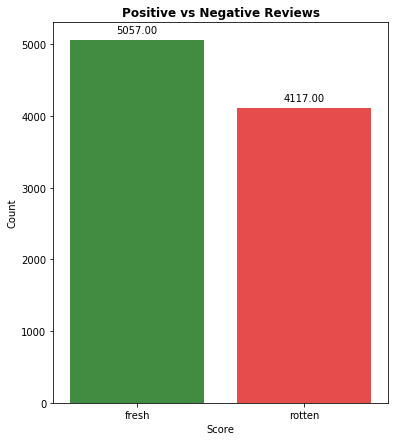

In [6]:
plt.figure(figsize=(6, 7))
splot = sns.countplot(df['Score'], alpha =.80, palette= ['green','red'])
for p in splot.patches:
    splot.annotate(format(p.get_height(), '.2f'), (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha = 'center', va = 'center', xytext = (0, 10), textcoords = 'offset points')
plt.title('Positive vs Negative Reviews', fontweight='bold')
plt.ylabel('Count')
plt.savefig('../Images/class_distribution.png')

# Cleaning and Preprocessing Data <a id='clean'></a>

Let's see what our text looks like so we can clean and tokenize it properly.

In [7]:
df['Review'][0]

"\n                                    Keough's work is so strong, so effective, that by the time we learn the ultimate fate of Grace, we would have bought into any of the possible options.\n                                "

We also need to be sure our scores/classes are represented as numbers.

In [8]:
df['Score'] = df['Score'].apply(lambda x: 0 if x == "rotten" else 1)
df.head()

,Review,Score
0,\n Keough's...,1
1,\n While Th...,1
2,"\n If ""The ...",1
3,"\n ""The Lod...",1
4,\n There's ...,0


For our stopwords, we use NLTK's english stopwords and add punctuation to these.

In [9]:
stopwords_list = stopwords.words('english')+list(string.punctuation)
print(stopwords_list)

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

To vectorize our data, we want to use TF-IDF, an advanced form of vectorization that weighs each term in a document by how unique it is to the given document it is contained in. We pass in our stop words and an ngram range of (1, 2). This range allows us to extract unigrams and bigrams from our text. 

In [10]:
vectorizer = TfidfVectorizer(stop_words=stopwords_list, ngram_range=(1, 2))
tf_idf_data = vectorizer.fit_transform(df['Review'])

In [11]:
tf_idf_data.shape

(9174, 100258)

Our vectorized data contains 9,174 reviews, with 100,258 unique words in the vocabulary.

In [12]:
sparse.save_npz("tf_idf.npz", tf_idf_data)

In [13]:
features = vectorizer.get_feature_names()

# EDA <a id='eda'></a>

Let's look at some statistics of our reviews. First, what are the most important words across all of our reviews?

In [14]:
top_words = top_mean_feats(tf_idf_data, features)
top_words

,Feature,TF-IDF
0,scary,0.003565
1,good,0.003536
2,one,0.003470
3,movie,0.003204
4,fun,0.003181
5,horror,0.002996
6,little,0.002823
7,well,0.002650
8,much,0.002639
9,enough,0.002634


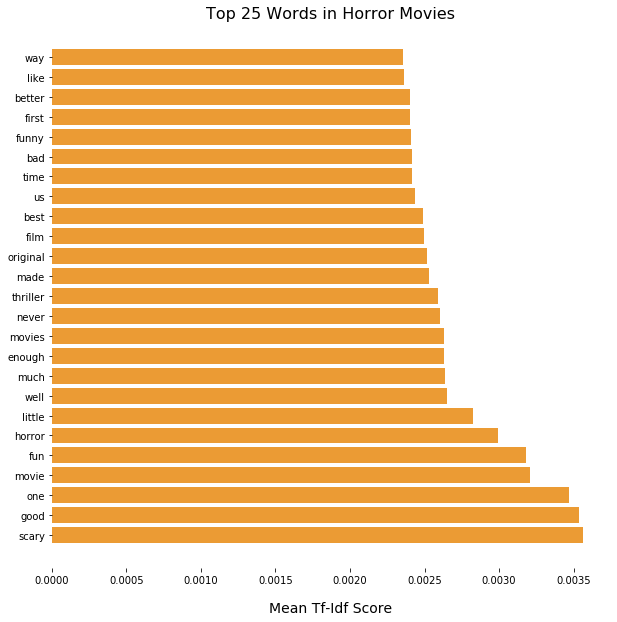

In [15]:
fig, ax = plt.subplots(figsize=(10, 10), facecolor="w")
ax.set_frame_on(False)
ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
ax.set_title("Top 25 Words in Horror Movies", fontsize=16)
ax.barh(top_words['Feature'], top_words['TF-IDF'], align='center', color='#eb9b34')
plt.savefig(f'../Images/top_words_horror.png')

There are some words here I don't believe provide any value, so I add them to the list of stopwords.

In [34]:
# add some unimportant words to stopwords list and remove from our reviews
stopwords_list += ['movie', 'movies', 'film', 'like']

vectorizer = TfidfVectorizer(stop_words=stopwords_list, ngram_range=(1, 2))
tf_idf_data = vectorizer.fit_transform(df['Review'])
sparse.save_npz("tf_idf.npz", tf_idf_data)

features = vectorizer.get_feature_names()
with open('features.pkl', 'wb') as f:
    pickle.dump(features, f)

In [17]:
tf_idf_data.shape

(9174, 98742)

Our vectorized data now contains 9,174 reviews, with 98,742 unique words in the vocabulary. Let's look at our most important words again.

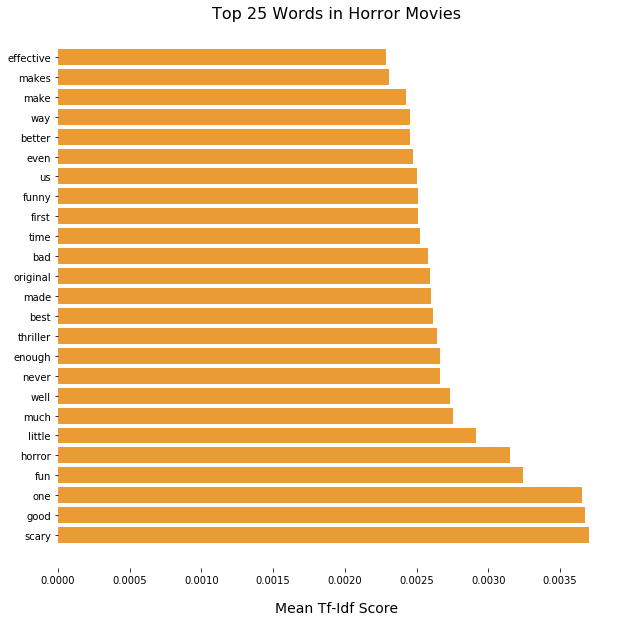

In [18]:
top_words = top_mean_feats(tf_idf_data, features)
fig, ax = plt.subplots(figsize=(10, 10), facecolor="w")
ax.set_frame_on(False)
ax.set_xlabel("Mean Tf-Idf Score", labelpad=16, fontsize=14)
ax.set_title("Top 25 Words in Horror Movies", fontsize=16)
ax.barh(top_words['Feature'], top_words['TF-IDF'], align='center', color='#eb9b34')
plt.savefig(f'../Images/top_words_horror.png')

This shows us what words are important for a movie review of the "horror" genre. Now, let's see which words are more important per class of review (negative vs positive).

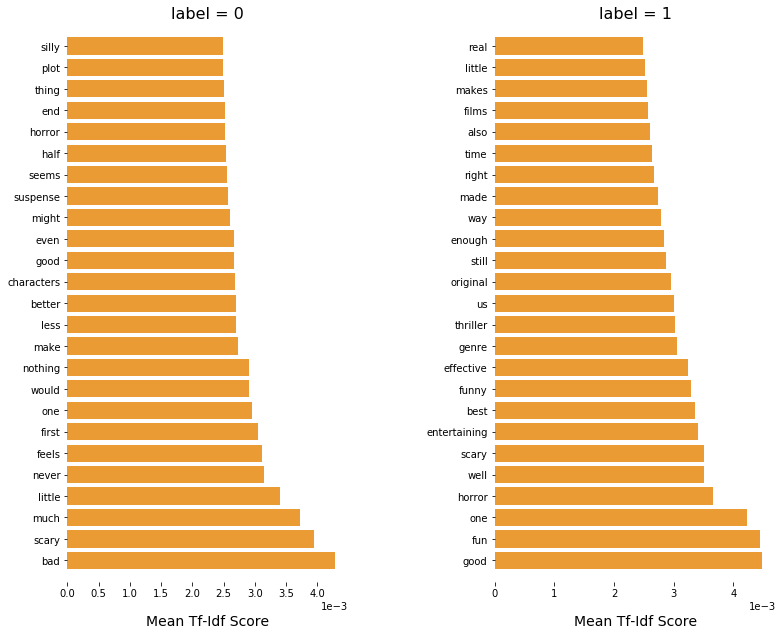

In [19]:
plot_tfidf_classfeats_h(top_feats_by_class(tf_idf_data,  df['Score'], features))

Lastly, we can also visualize these using word clouds. Let's look at the top 50 words for horror genre, positive reviews, and negative reviews.

In [20]:
horror_50 = top_mean_feats(tf_idf_data, features, top_n=50)
weights = {}
for i in range(len(horror_50['Feature'])):
    weights[horror_50['Feature'][i]] = horror_50['TF-IDF'][i]

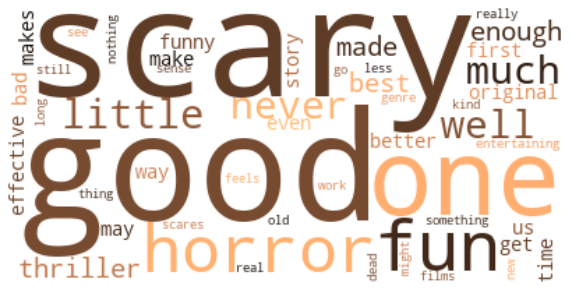

In [21]:
wordcloud = WordCloud(max_words=50, background_color="white", colormap="copper").generate_from_frequencies(weights)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [22]:
wordcloud.to_file("../Images/all_reviews_cloud.png")

In [23]:
dfs = top_feats_by_class(tf_idf_data,  df['Score'], features, top_n=50)
neg_50 = dfs[0]
pos_50 = dfs[1]

In [24]:
weights = {}
for i in range(len(neg_50['Feature'])):
    weights[neg_50['Feature'][i]] = neg_50['TF-IDF'][i]

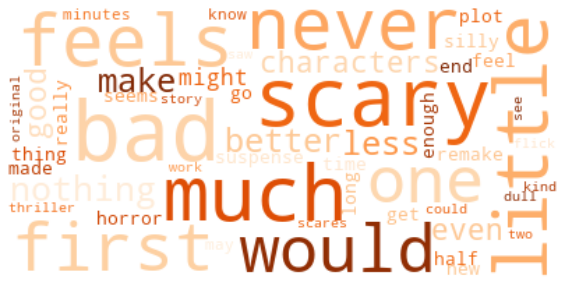

In [25]:
wordcloud = WordCloud(max_words=50, background_color="white", colormap="Oranges").generate_from_frequencies(weights)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [26]:
wordcloud.to_file("../Images/neg_reviews_cloud.png")

In [27]:
weights = {}
for i in range(len(pos_50['Feature'])):
    weights[pos_50['Feature'][i]] = pos_50['TF-IDF'][i]

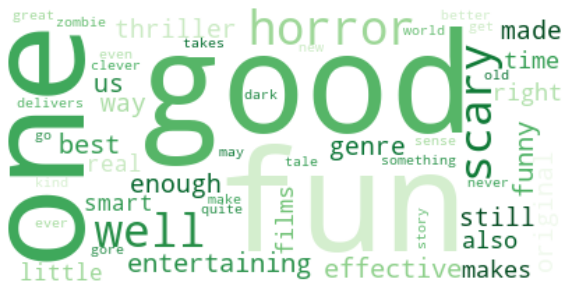

In [28]:
wordcloud = WordCloud(max_words=50, background_color="white", colormap="Greens").generate_from_frequencies(weights)
plt.figure(figsize=(10,10))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

In [29]:
wordcloud.to_file("../Images/pos_reviews_cloud.png")